In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

## Loading and normalizing CIFAR10

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainSet = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=True, transform=transform)
testSet = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=True, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=4, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=4, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import matplotlib.pyplot as plt
import numpy as np

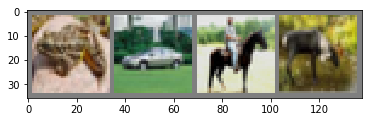

 frog   car horse  deer


In [7]:
# functions to show an image
def showImage(img):
  img = img / 2 + 0.5 #unnormalize
  npImg = img.numpy()
  plt.imshow(np.transpose(npImg, (1, 2, 0)))
  plt.show()
  
  
#get some random training images
dataIter = iter(trainLoader)
images, labels = dataIter.next()

#show images
showImage(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

  

## Defina a CNN

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  
net = Net()
    
    
    

## Define a Loss function and optimizer

In [0]:
import torch.optim as optim

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [13]:
for epoch in range(2):
  
  runningLoss = 0.
  for i, data in enumerate(trainLoader, 0):
    #get the inputs
    inputs, labels = data
    
    # zero the parameter gradients
    optimizer.zero_grad()
    
    #forward + forward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    #print statistics
    runningLoss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, runningLoss / 2000))
      runningLoss = 0.
     
    
print('Finished Training')

[1,  2000] loss: 1.862
[1,  4000] loss: 1.710
[1,  6000] loss: 1.621
[1,  8000] loss: 1.544
[1, 10000] loss: 1.503
[1, 12000] loss: 1.441
[2,  2000] loss: 1.395
[2,  4000] loss: 1.363
[2,  6000] loss: 1.338
[2,  8000] loss: 1.316
[2, 10000] loss: 1.267
[2, 12000] loss: 1.269
Finished Training


## Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.



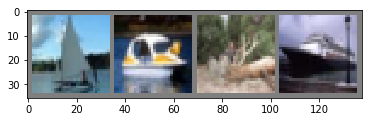

GroundTruth:   ship  ship  deer  ship


In [15]:
dataIter = iter(testLoader)
images, labels = dataIter.next()

# print images
showImage(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Lets see what the neural network thinks these examples above are:

In [0]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   ship  ship  frog  ship


Let us look at how the network performs on the whole dataset.



In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


What are the classes that performed well, and the classes that did not perform well:

In [19]:
classCorrect = list(0. for i in range(10))
classTotal = list(0. for i in range(10))
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            classCorrect[label] += c[i].item()
            classTotal[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * classCorrect[i] / classTotal[i]))

Accuracy of plane : 59 %
Accuracy of   car : 65 %
Accuracy of  bird : 38 %
Accuracy of   cat : 50 %
Accuracy of  deer : 50 %
Accuracy of   dog : 30 %
Accuracy of  frog : 61 %
Accuracy of horse : 54 %
Accuracy of  ship : 77 %
Accuracy of truck : 65 %


## Training on GPU

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

inputs, labels = inputs.to(device), labels.to(device)